Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Paramètres financiers

In [2]:
S = 50 # Valeur du sous-jacent
K = 50 # Strike
r = 0.05 # Taux d'intérêt sans risque
sigma = 0.2 # Volatilité
T = 3 # Maturité

Paramètres numériques

In [3]:
M = 80 # Nombre  de points de maillage d'actifs
N = 200 # Nombre de points de maillage en temps
# Valuers extrêmes
Szero = 0
Smax = 150
# Paramètres SOR
omega = 1.2
tol = 0.001

Initialisation du maillage et de la matrice du système linéaire

In [4]:
sol = np.zeros((N + 1, M + 1)) # Solution

# Step
dS = Smax / M
dt = T / N

# Mesh
Smesh = np.arange(0, Smax + 1, dS)
Tmesh = np.arange(T, -1e-10, -dt)

# Payoff
sol[0, :] = np.array([np.maximum(K - Smesh[t], 0) for t in range(Smesh.shape[0])])

# Limit condition for S = 0
sol[:, 0] = K * np.exp(-r * (T - Tmesh)) 
# Limit condition for S = M
sol[:, M] = 0 

i = np.arange(1, M + 1)
A = 0.5 * dt * (r * i - sigma**2 * i**2)
B = 1 + (sigma**2 * i**2 + r) * dt
C = -0.5 * dt *(sigma**2 * i**2 + r * i)

Construction de la matrice tri-diagonale et son inverse

In [5]:
Acoeffs = np.zeros((M))
Bcoeffs = np.zeros((M))
Ccoeffs = np.zeros((M))

for i in range(M):
    Acoeffs[i] = A[i-1]
    Bcoeffs[i] = B[i-1]
    Ccoeffs[i] = C[i-1]
    
Tri = diags([Acoeffs[2:], Bcoeffs[1:], Ccoeffs[1:-1]], [-1, 0, 1], shape=(M - 1, M - 1), dtype=float).toarray()

Tri_inv =  np.linalg.inv(Tri)

Boucle en temps et schéma implicite + itération SOR

In [21]:
for p in range(N):
    temp = np.zeros((M - 1))
    temp[0] = A[0] * sol[p + 1, 0]
    temp[-1] = C[M - 1] * sol[p + 1, -1]
    
    RHS = sol[p, 1:M].T - temp
    
    x = sol[p, 1:M - 1].T
    xold = 10000 * x
    n = len(x)
    
    while np.linalg.norm(xold - x) > tol:
        xold = x
        
        for i in range(n):
            if i == 0:
                z = (RHS[i] - Tri[i, i + 1] * x[i + 1]) / Tri[i, i]
            elif i == n - 1:
                z = (RHS[i] - Tri[i, i - 1] * x[i - 1]) / Tri[i, i]
            else:
                z = (RHS[i] - Tri[i, i - 1] * x[i - 1] - Tri[i, i + 1] * x[i + 1]) / Tri[i, i]
            x[i] = np.maximum(omega * z + (1 - omega) * xold[i], K - (i + 1) * dS)
    
    sol[p + 1, 1:-2] = x


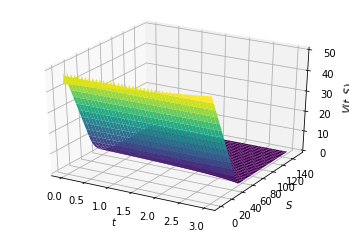

In [29]:
[Smat, tmat] = np.meshgrid(Smesh, Tmesh)

fig = plt.figure()
ax = fig.gca(projection='3d')

#axis labels
ax.set_xlabel('$t$')
ax.set_ylabel('$S$')
ax.set_zlabel('$V(t,S)$')
surf = ax.plot_surface(tmat, Smat, np.reshape(sol, (Smat.shape)), cmap=cm.viridis,
                   antialiased=True)
plt.show()

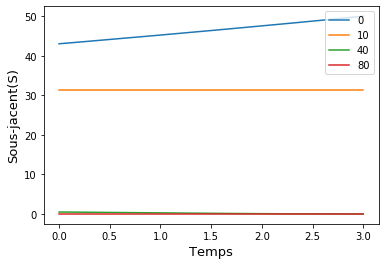

In [39]:
plt.plot(Tmesh, sol[:, 0], label='0')
plt.plot(Tmesh, sol[:, 10], label='10')
plt.plot(Tmesh, sol[:, 40], label='40')
plt.plot(Tmesh, sol[:, 80], label='80')
plt.legend()
plt.xlabel('Temps', fontsize=13)
plt.ylabel('Sous-jacent(S)', fontsize=13)
plt.show()